### Data Sourcing
Obtain the data from 1 Oct 2012 to 30 September 2022 for the following: (say)
2012-10-01 to 2022-09-30
1. SPY (SPDR S & P 500 ETF)
2. XLE (Energy Sector SPDR)
3. VNQ (Real Estate)
4. XLF (Finance Sector SPDR)

In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

import matplotlib.pyplot as plt
import numpy as np
import plotly as plotly
from scipy.stats import lognorm,shapiro,normaltest,norm
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
yahoo_financials = YahooFinancials('SPY')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
spy_df = pd.DataFrame(data['SPY']['prices'])
spy_df = spy_df.drop('date', axis=1).set_index('formatted_date')
spy_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,147.160004,143.830002,144.520004,146.139999,619770200,120.519798
2012-10-08,146.119995,142.580002,145.600006,142.889999,599319200,117.839584
2012-10-15,146.520004,142.770004,143.229996,143.389999,679092400,118.251839
2012-10-22,143.669998,140.389999,143.149994,141.350006,718295200,116.569557
2012-10-29,143.720001,140.679993,141.850006,141.559998,342136300,116.742699


In [3]:
yahoo_financials = YahooFinancials('XLE')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
xle_df = pd.DataFrame(data['XLE']['prices'])
xle_df = xle_df.drop('date', axis=1).set_index('formatted_date')
xle_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,74.529999,72.669998,73.940002,73.580002,57754800,50.376877
2012-10-08,74.379997,72.040001,73.169998,72.559998,49958700,49.678532
2012-10-15,75.190002,71.910004,72.430000,73.830002,60294000,50.548050
2012-10-22,74.099998,71.019997,73.860001,71.959999,57769500,49.267750
2012-10-29,72.690002,70.820000,72.250000,71.059998,31881500,48.651543


In [4]:
yahoo_financials = YahooFinancials('XLF')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
xlf_df = pd.DataFrame(data['XLF']['prices'])
xlf_df = xlf_df.drop('date', axis=1).set_index('formatted_date')
xlf_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,13.184403,12.688871,12.753859,13.046304,360107630,10.720538
2012-10-08,13.103168,12.802600,12.981316,12.843217,370064697,10.553652
2012-10-15,13.314379,12.835093,12.891958,13.086921,372740399,10.753915
2012-10-22,13.119415,12.745735,13.070674,12.835093,408311252,10.546979
2012-10-29,13.160032,12.826970,12.883834,12.997563,191163467,10.680485


In [5]:
yahoo_financials = YahooFinancials('VNQ')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
vnq_df = pd.DataFrame(data['VNQ']['prices'])
vnq_df = vnq_df.drop('date', axis=1).set_index('formatted_date')
vnq_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,65.680000,63.820000,65.099998,65.169998,14488300,43.299446
2012-10-08,65.529999,64.680000,64.830002,64.769997,9381600,43.033691
2012-10-15,66.320000,64.459999,64.790001,65.540001,11433000,43.545288
2012-10-22,65.550003,63.400002,65.489998,63.759998,9668400,42.362648
2012-10-29,65.570000,63.740002,64.040001,65.120003,7515200,43.266247


In [6]:
combined_prices_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_prices_df['SPY'] = spy_df['adjclose']
combined_prices_df['VNQ'] = vnq_df['adjclose']
combined_prices_df['XLE'] = xle_df['adjclose']
combined_prices_df['XLF'] = xlf_df['adjclose']
combined_prices_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-10-01,120.519798,43.299446,50.376877,10.720538
2012-10-08,117.839584,43.033691,49.678532,10.553652
2012-10-15,118.251839,43.545288,50.548050,10.753915
2012-10-22,116.569557,42.362648,49.267750,10.546979
2012-10-29,116.742699,43.266247,48.651543,10.680485


<AxesSubplot:xlabel='formatted_date'>

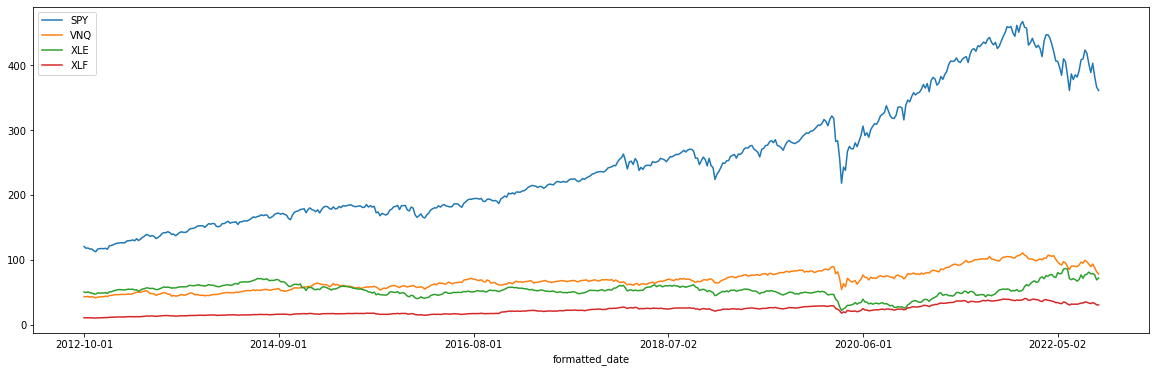

In [7]:
combined_prices_df.plot(kind='line', figsize=(20,6))

In [8]:
combined_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_rets_df['SPY'] = spy_df['adjclose'].pct_change()
combined_rets_df['VNQ'] = vnq_df['adjclose'].pct_change()
combined_rets_df['XLE'] = xle_df['adjclose'].pct_change()
combined_rets_df['XLF'] = xlf_df['adjclose'].pct_change()
combined_rets_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-10-01,NaN,NaN,NaN,NaN
2012-10-08,-0.022239,-0.006138,-0.013862,-0.015567
2012-10-15,0.003498,0.011888,0.017503,0.018976
2012-10-22,-0.014226,-0.027159,-0.025328,-0.019243
2012-10-29,0.001485,0.021330,-0.012507,0.012658


<AxesSubplot:xlabel='formatted_date'>

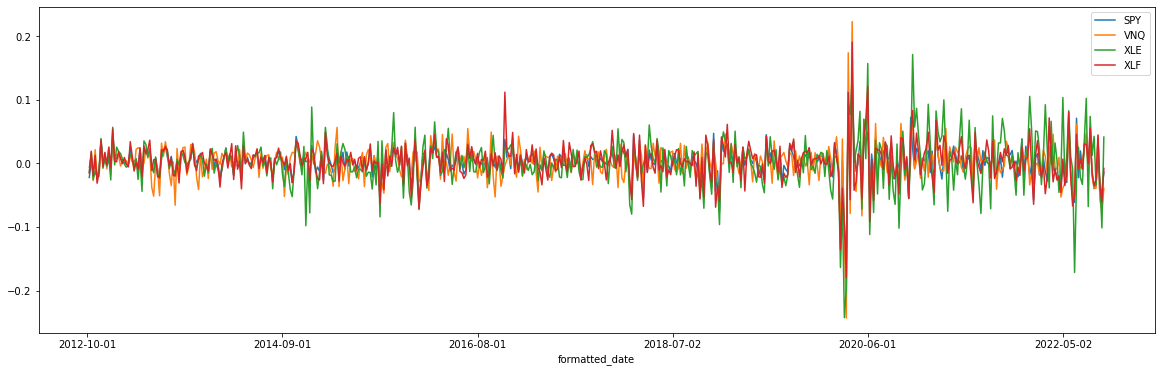

In [9]:
combined_rets_df.plot(kind='line', figsize=(20,6))

In [10]:
rec_count=20000
combined_log_rets_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_log_rets_df['SPY'] = np.log(spy_df['adjclose'])-np.log(spy_df['adjclose'].shift(1))
combined_log_rets_df['VNQ'] = np.log(vnq_df['adjclose'])-np.log(vnq_df['adjclose'].shift(1))
combined_log_rets_df['XLE'] = np.log(xle_df['adjclose'])-np.log(xle_df['adjclose'].shift(1))
combined_log_rets_df['XLF'] = np.log(xlf_df['adjclose'])-np.log(xlf_df['adjclose'].shift(1))
combined_log_rets_df.head()

,SPY,VNQ,XLE,XLF
formatted_date,,,,
2012-10-01,NaN,NaN,NaN,NaN
2012-10-08,-0.022490,-0.006157,-0.013959,-0.015689
2012-10-15,0.003492,0.011818,0.017351,0.018798
2012-10-22,-0.014328,-0.027534,-0.025655,-0.019430
2012-10-29,0.001484,0.021106,-0.012586,0.012579


<AxesSubplot:xlabel='formatted_date'>

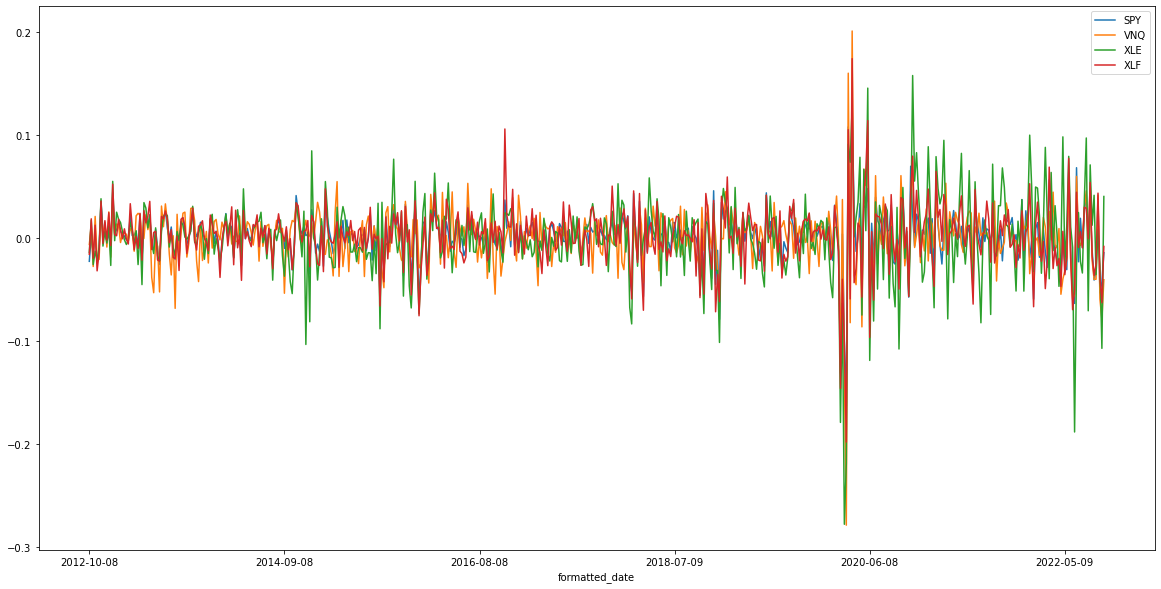

In [11]:
combined_log_rets_df.dropna(inplace = True),
combined_log_rets_df=combined_log_rets_df[-rec_count:]
combined_log_rets_df.plot(kind='line', figsize=(20,10))

### Test for normality

Text(0.5, 0, 'StdDev')

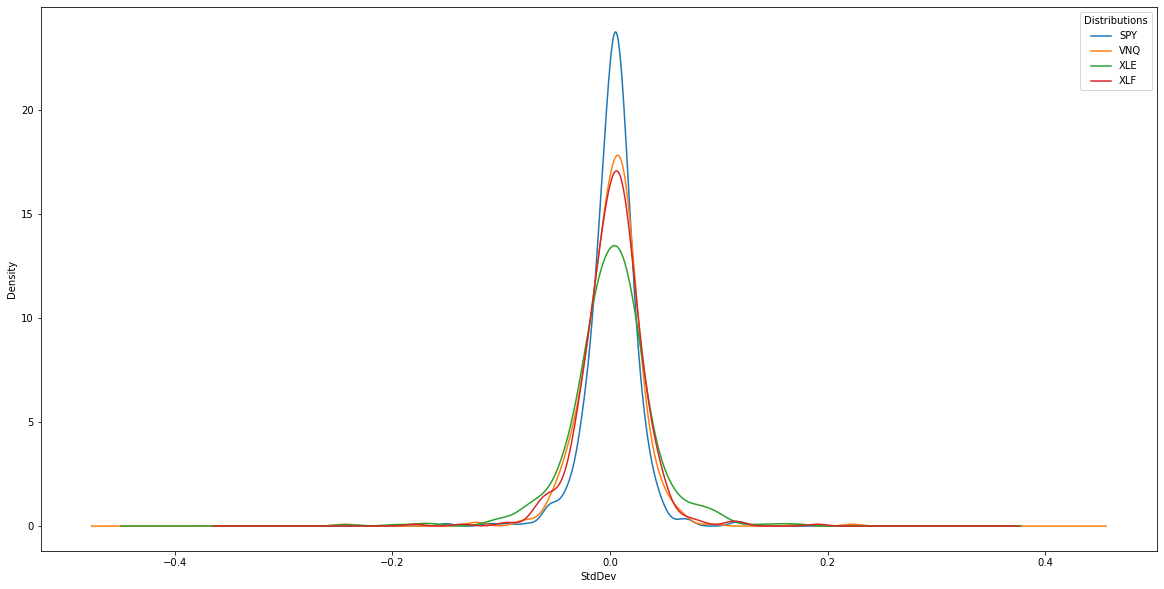

In [12]:
#plot distribution of points by team 
combined_rets_df.plot(kind='kde', figsize=(20,10))

#add legend
plt.legend(['SPY','VNQ','XLE','XLF'], title='Distributions')

#add x-axis label
plt.xlabel('StdDev')

In [39]:
combined_rets_df.describe()

,SPY,VNQ,XLE,XLF
count,521.000000,521.000000,521.000000,521.000000
mean,0.002368,0.001581,0.001456,0.002441
std,0.022662,0.029707,0.038948,0.029477
min,-0.150453,-0.243259,-0.242588,-0.179610
25%,-0.008686,-0.012635,-0.015711,-0.011780
50%,0.003844,0.003495,0.003185,0.003714
75%,0.014013,0.016442,0.021200,0.017481
max,0.120915,0.222842,0.171103,0.190428


#### QQ Plot

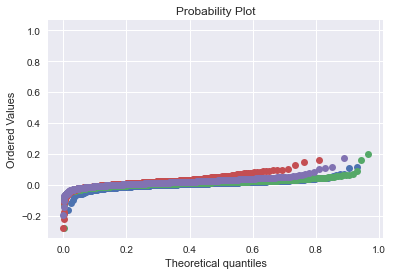

In [13]:
import scipy.stats as stats

plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
stats.probplot(combined_log_rets_df['SPY'], dist=stats.beta, sparams=(2,3), plot=plt, fit=False)
stats.probplot(combined_log_rets_df['VNQ'], dist=stats.beta, sparams=(1,2), plot=plt, fit=False)
stats.probplot(combined_log_rets_df['XLE'], dist=stats.beta, sparams=(1,4), plot=plt, fit=False)
stats.probplot(combined_log_rets_df['XLF'], dist=stats.beta, sparams=(1,3), plot=plt, fit=False)

# Remove the regression lines
ax.get_lines()[1].remove()
ax.get_lines()[2].remove()
ax.get_lines()[3].remove()
ax.get_lines()[4].remove()

# Change colour of scatter
ax.get_lines()[0].set_markerfacecolor('C0')
ax.get_lines()[1].set_markerfacecolor('C1')
ax.get_lines()[2].set_markerfacecolor('C2')
ax.get_lines()[3].set_markerfacecolor('C3')

# Add on y=x line
ax.plot([0, 0], [1, 1], c='C4')

In [14]:
# Normal QQ Plot for Returns
'''
stock_symbol = 'SPY'
qq = sm.qqplot(combined_rets_df['SPY'],norm, fit=True, line="q")
qq.set_size_inches((7, 5))
plt.title(f"Normal QQ Plot for {stock_symbol} Return")
plt.show()
'''

'\nstock_symbol = \'SPY\'\nqq = sm.qqplot(combined_rets_df[\'SPY\'],norm, fit=True, line="q")\nqq.set_size_inches((7, 5))\nplt.title(f"Normal QQ Plot for {stock_symbol} Return")\nplt.show()\n'

#### Stationarity - ADF test

In [15]:
import statsmodels.tsa.stattools as st

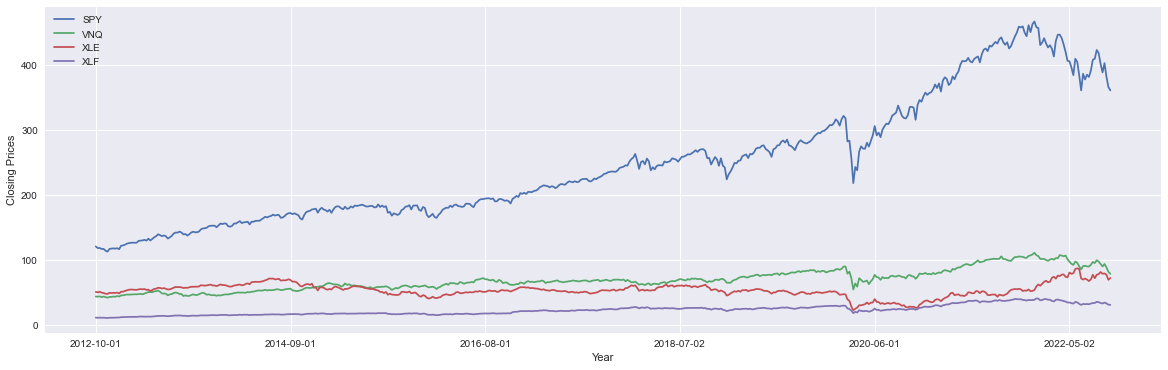

In [16]:
combined_prices_df.plot(kind='line', figsize=(20,6))
plt.ylabel("Closing Prices")
plt.xlabel("Year")
plt.show()

In [17]:
combined_adf_df = pd.DataFrame(columns=['SPY','VNQ','XLE','XLF'])
combined_adf_df['SPY'] = st.adfuller(x=spy_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
combined_adf_df['VNQ'] = st.adfuller(x=vnq_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
combined_adf_df['XLE'] = st.adfuller(x=xle_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
combined_adf_df['XLF'] = st.adfuller(x=xlf_df['adjclose'], autolag="AIC") #regression="ct", maxlag=12)
print("spy adf:", combined_adf_df['SPY'][0], "adf_pvalue:", combined_adf_df['SPY'][1])
print("vnq adf:", combined_adf_df['VNQ'][0], "adf_pvalue:", combined_adf_df['VNQ'][1])
print("xle adf:", combined_adf_df['XLE'][0], "adf_pvalue:", combined_adf_df['XLE'][1])
print("xlf adf:", combined_adf_df['XLF'][0], "adf_pvalue:", combined_adf_df['XLF'][1])

spy adf: -0.9166461798467874 adf_pvalue: 0.7824411764666118
vnq adf: -1.7413042936182153 adf_pvalue: 0.4099666532094824
xle adf: -1.5457550383790832 adf_pvalue: 0.5107679076227388
xlf adf: -1.3794396365412642 adf_pvalue: 0.5920923655751986


In [18]:
# Here p-value is far bigger than 0.005, so we can't reject null hypothesis, and can be concluded its not stationary.

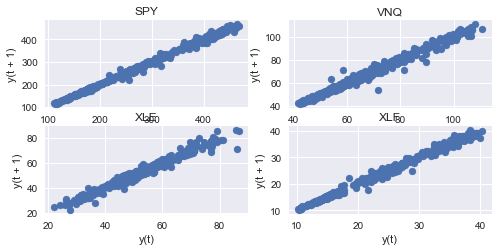

In [19]:
#import seaborn as sns
#c1 = sns.color_palette("YlOrRd_r", 4)
plt.subplot(321, title='SPY')
pd.plotting.lag_plot(combined_prices_df['SPY'], lag=1)

plt.subplot(322, title='VNQ')
pd.plotting.lag_plot(combined_prices_df['VNQ'], lag=1)

plt.subplot(323, title='XLE')
pd.plotting.lag_plot(combined_prices_df['XLE'], lag=1)

plt.subplot(324, title='XLF')
pd.plotting.lag_plot(combined_prices_df['XLF'], lag=1)

plt.show()

# Correlation is calculated between the variable 
# and itself at previous time steps, such a correlation is called Autocorrelation.

In [20]:
# As we can see from the above tests and QQ plot the returns are not normally distributed. 
# Any analysis assuming the normal distribution of the data will not be applicable to these returns.

#### Regime shift tests

In [21]:
from statsmodels.tsa.stattools import adfuller
print("SPY: \n", adfuller(combined_rets_df['SPY'].dropna()))
print("VNQ: \n", adfuller(combined_rets_df['VNQ'].dropna()))
print("XLE: \n", adfuller(combined_rets_df['XLE'].dropna()))
print("XLF: \n", adfuller(combined_rets_df['XLF'].dropna()))

SPY: 
 (-24.708637537869116, 0.0, 0, 520, {'1%': -3.4429882202506255, '5%': -2.8671142122781066, '10%': -2.569738849852071}, -2363.4990394815463)
VNQ: 
 (-8.610526863617956, 6.494436306674966e-14, 7, 513, {'1%': -3.443161545965353, '5%': -2.8671904981615706, '10%': -2.5697795041589244}, -2102.621736065494)
XLE: 
 (-8.207529995073937, 6.959418391223192e-13, 10, 510, {'1%': -3.4432372923913124, '5%': -2.86722383510113, '10%': -2.5697972702806613}, -1824.5247633715926)
XLF: 
 (-14.234708938154466, 1.5745260474082424e-26, 2, 518, {'1%': -3.443037261465839, '5%': -2.8671357972350493, '10%': -2.569750352856994}, -2099.051920760908)


#### Markov Switching Autoregressive Model

In [22]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['SPY'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    SPY   No. Observations:                  521
Model:               MarkovRegression   Log Likelihood                1333.388
Date:                Fri, 10 Mar 2023   AIC                          -2648.777
Time:                        13:09:11   BIC                          -2610.475
Sample:                    10-08-2012   HQIC                         -2633.774
                         - 09-26-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   2.02e-05      8.946      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008      0.000      7.299      0.000       0.001       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0086      0.005      1.886      0.059      -0.000       0.018
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9779      0.011     93.130      0.000       0.957       0.998
p[1->0]        0.0438        nan        nan        nan         nan         nan
p[2->0]     1.349e-11        nan        nan        nan         nan         nan
p[0->1]        0.0189      0.010      1.883      0.060      -0.001       0.039
p[1->1]        0.9562        nan        nan        nan         nan         nan
p[2->1]        0.1366      0.127      1.078      0.281      -0.112       0.385
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

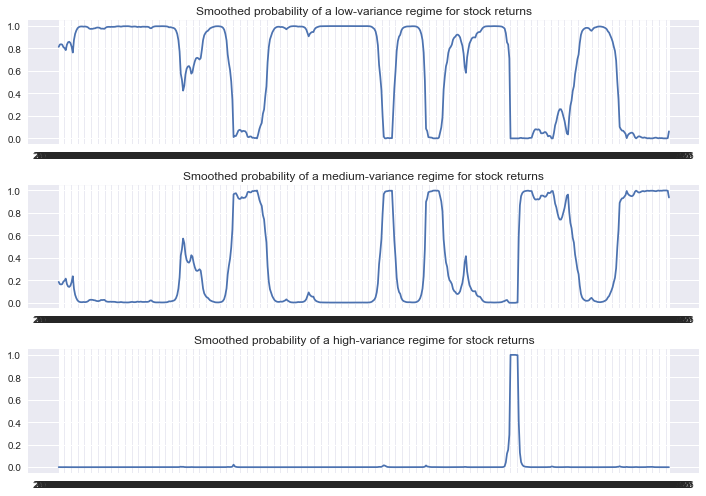

In [23]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

In [24]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['VNQ'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                    VNQ   No. Observations:                  521
Model:               MarkovRegression   Log Likelihood                1219.927
Date:                Fri, 10 Mar 2023   AIC                          -2421.854
Time:                        13:10:21   BIC                          -2383.553
Sample:                    10-08-2012   HQIC                         -2406.851
                         - 09-26-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   2.95e-05     13.893      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0016      0.000      4.632      0.000       0.001       0.002
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0214      0.012      1.829      0.067      -0.002       0.044
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9949      0.004    270.205      0.000       0.988       1.002
p[1->0]        0.0283        nan        nan        nan         nan         nan
p[2->0]     1.366e-15        nan        nan        nan         nan         nan
p[0->1]        0.0028      0.003      0.923      0.356      -0.003       0.009
p[1->1]        0.9717        nan        nan        nan         nan         nan
p[2->1]        0.1316      0.126      1.049      0.294      -0.114       0.378
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

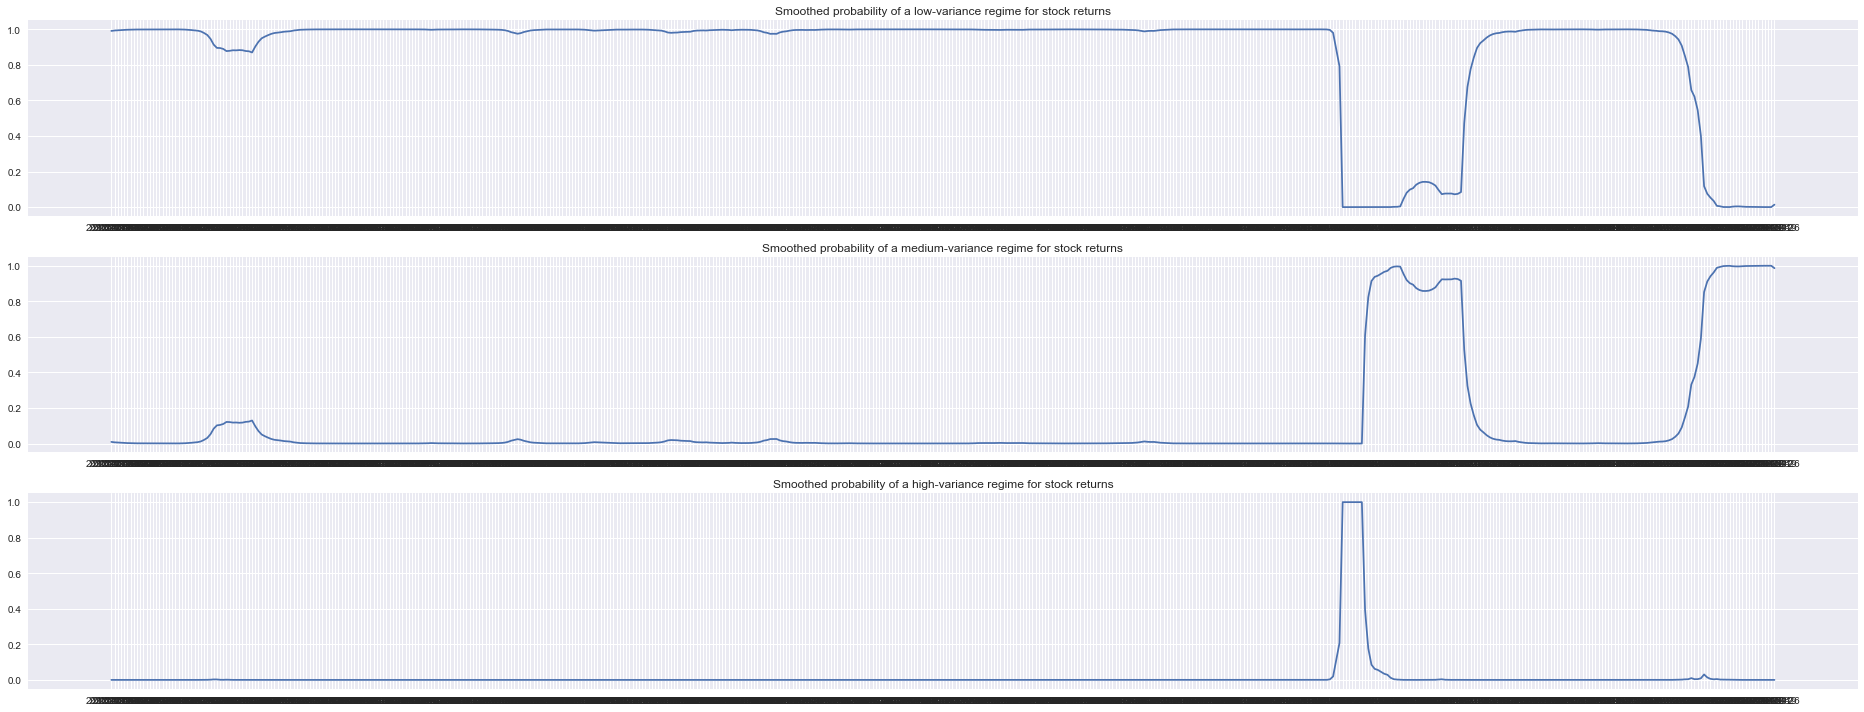

In [25]:
fig, axes = plt.subplots(3, figsize=(26,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


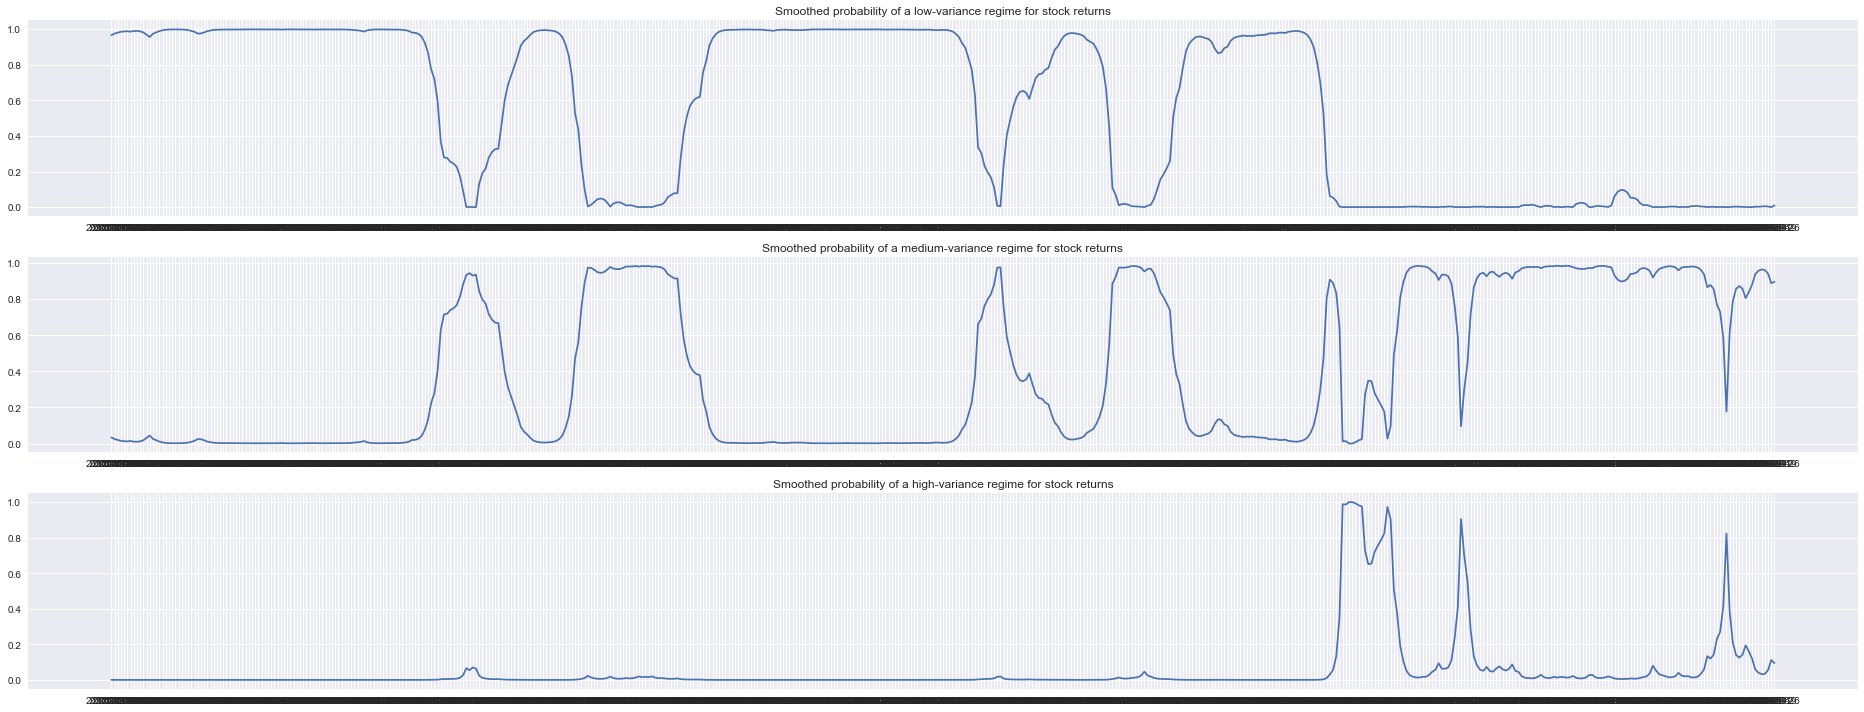

In [26]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['XLE'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

fig, axes = plt.subplots(3, figsize=(26,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

C:\Users\krish\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


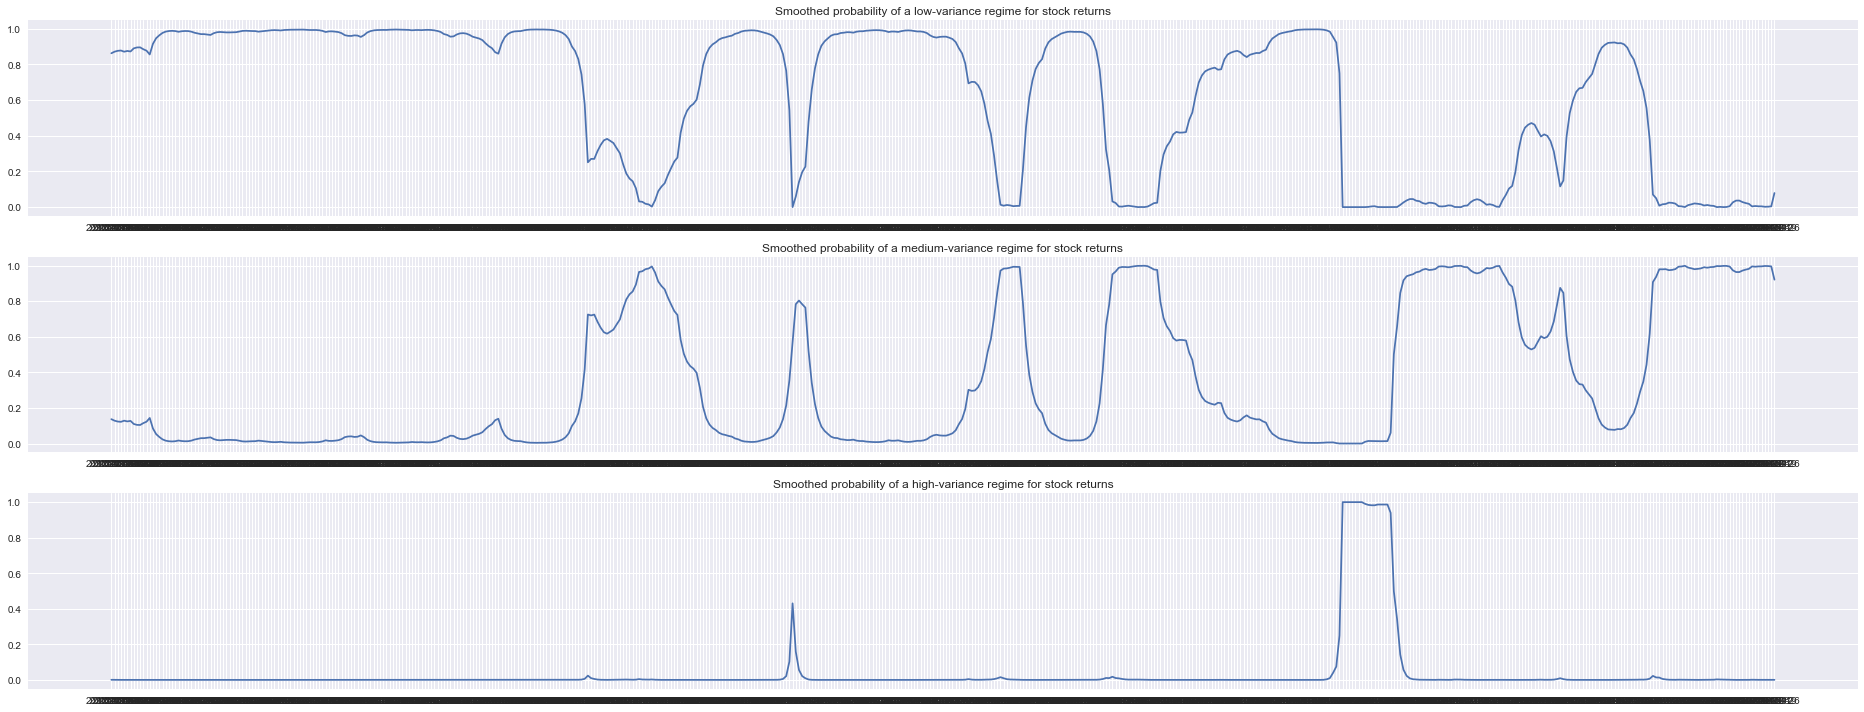

In [27]:
mod_kns = sm.tsa.MarkovRegression(combined_rets_df['XLF'].dropna(), k_regimes=3, trend='nc', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

fig, axes = plt.subplots(3, figsize=(26,10))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

#### Correlation Matrix of prices

In [28]:
import seaborn as sb

In [29]:
corr = combined_prices_df.corr(method="pearson")
corr

,SPY,VNQ,XLE,XLF
SPY,1.000000,0.95966,-0.033180,0.973104
VNQ,0.959660,1.00000,0.005160,0.955630
XLE,-0.033180,0.00516,1.000000,0.066417
XLF,0.973104,0.95563,0.066417,1.000000


<AxesSubplot:>

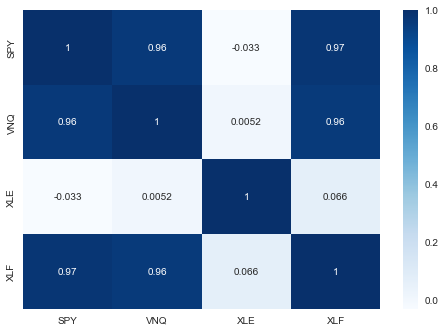

In [30]:
sb.heatmap(corr, cmap="Blues", annot=True)

In [31]:
corr = combined_prices_df.corr(method="kendall")
corr

,SPY,VNQ,XLE,XLF
SPY,1.000000,0.846688,-0.133859,0.875828
VNQ,0.846688,1.000000,-0.147760,0.798032
XLE,-0.133859,-0.147760,1.000000,-0.050540
XLF,0.875828,0.798032,-0.050540,1.000000


<AxesSubplot:>

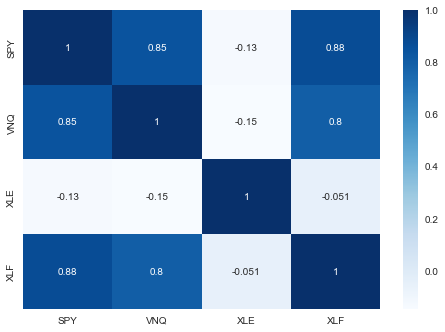

In [32]:
sb.heatmap(corr, cmap="Blues", annot=True)

In [33]:
corr = combined_prices_df.corr(method="spearman")
corr

,SPY,VNQ,XLE,XLF
SPY,1.000000,0.963767,-0.203729,0.968245
VNQ,0.963767,1.000000,-0.207884,0.934242
XLE,-0.203729,-0.207884,1.000000,-0.088474
XLF,0.968245,0.934242,-0.088474,1.000000


<AxesSubplot:>

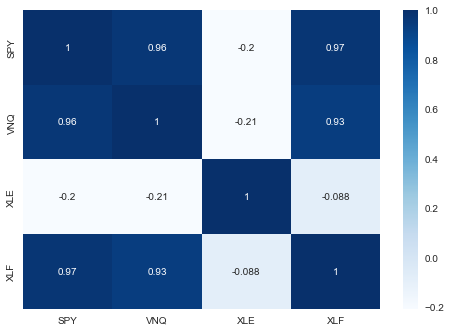

In [34]:
sb.heatmap(corr, cmap="Blues", annot=True)

### PCA analysis

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
# You must normalize the data before applying the fit method
df_normalized=(combined_prices_df - combined_prices_df.mean()) / combined_prices_df.std()
pca = PCA(n_components=combined_prices_df.shape[1])
pca.fit(df_normalized)

PCA(n_components=4)

In [36]:
# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=combined_prices_df.columns)
print(loadings)

          PC0       PC1       PC2       PC3
SPY  0.578561 -0.053428 -0.361113  0.729390
VNQ  0.575213 -0.014661  0.816135 -0.053279
XLE  0.011512  0.997300  0.014441  0.071070
XLF  0.578157  0.048193 -0.450901 -0.678307


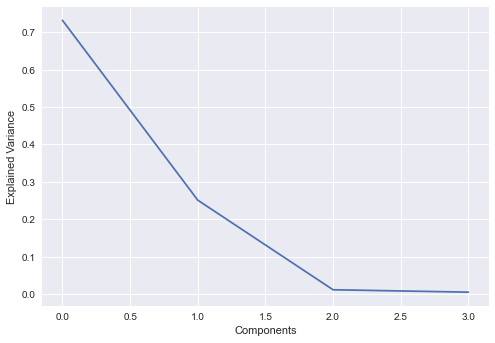

In [37]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

## APPENDIX
some extra code which may be useful for experiments are kept here, Not to use in thesis writing now.

In [97]:
from fredapi import Fred
# FRED API key
fred_key = "0e42125b8d25e5d7a6b4f26132eb7b1e";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API

fed_effective_rates_df = pd.DataFrame(fred.get_series('FEDFUNDS'));

In [98]:
fed_effective_rates_df.head()

,0
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


After discussion with Kenneth Abott:
    
    1. Working with weekly data,
    2. Test for statistical distributions
    3. Do different tests including ADF
    4. Check first order serial autocorrelation
    5. Plotting graphs, correlation matrices,
    6. Check regime shift, 
    7. Basic statistical analysis from dispersion (skewness, kurtosis). 

#### Resampling

In [ ]:
#TBD

#### Gathering data from Fred for Indicators purpose

In [ ]:
#TBD

### Data Display
#### Plotting for Outliers

In [ ]:
# TBD
# Boxplot
# Correlation heat map

##### Cluster correlation analysis

In [ ]:
# TBD
# cluster correlation matrix
# Scatter plot
# Time series plot
# Density plot


#### Calculating Daily Returns

In [ ]:
# TBD

In [ ]:
# PCA Analsis
# Extreme value tracing
# Modelling Data
## QQ Plot normalization
# Jorgue -Berra Test
# QQ Plot normalization 

# Gaussian F-test
# Normalization test
# 

## Model - fitting
# Copula
# Gaussian Copula
# Normal distribution
# Non Gaussian Copula
# Model Vine Copula
# 

## Regime Tests
#  Get data 
# CADF model function
# mean reverting relationship
# 